In [2]:
import torch
from torch import nn
import torch.optim as optim
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

#处理数据

In [2]:
#定义函数解压pickled文件
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
print(unpickle(r"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py\data_batch_1").keys())
data=unpickle(r"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py\data_batch_1")[b'data']
print(data)
print(data.shape)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
(10000, 3072)


#处理数据

In [11]:
class MyDataset(Dataset):
    def __init__(self,mode="train",transform=None):
        if mode=="train":
            self.data=[]
            self.label=[]
            self.transform=transform
            for i in range(1,6):
                data_dict=unpickle(rf"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py\data_batch_{i}")
                data=data_dict[b'data'].reshape(10000,3,32,32)
                data=data.transpose(0,2,3,1)
                # for i in range(10000):
                #     data[i]=Image.fromarray(data[i])
                if len(self.data)==0:
                    self.data = data
                    self.label = data_dict[b'labels']
                else:
                    self.data = np.concatenate((self.data, data), axis=0)  # 按行拼接
                    self.label = np.concatenate((self.label, data_dict[b'labels']), axis=0) 
        else:
            self.data=[]
            self.label=[]
            self.transform=transform
            data_dict=unpickle(r"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py\test_batch")
            data=data_dict[b'data'].reshape(10000,3,32,32)
            data=data.transpose(0,2,3,1)
            # for i in range(10000):
            #         data[i]=Image.fromarray(data[i])
            self.data=data
            self.label = data_dict[b'labels']  
    
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # 根据索引返回数据和标签
        data = self.data[idx]
        label = self.label[idx]
        if self.transform:
            data=self.transform(data)
            label = torch.tensor(label).long()
        return data,label
    
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset=MyDataset('train',transform)
test_dataset=MyDataset('test',transform)

# plt.figure(figsize=(5,5))
# plt.imshow(train_dataset0.data[0])
#plt.imshow(test_dataset0.data[0])
# plt.axis('off')
# plt.show

# train_dataset.data=torch.from_numpy(train_dataset.data)
# test_dataset.data=torch.from_numpy(test_dataset.data)


train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)
print(train_loader)


data1=train_dataset.data
data11=data1.reshape(50000,3,1024)
data111=data1.reshape(50000,3,32,32)
data=data111.transpose(0,2,3,1)
print(data1)
print(data11)
print(data111)
print(data) 
PIL_image=Image.fromarray(data)
plt.figure(figsize=(5,5))
plt.imshow(PIL_image)
plt.axis('off')
plt.show
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
datatransform=transform(data)
print(datatransform)

In [3]:
model=nn.Sequential(
    nn.Conv2d(3,20,kernel_size=5,padding=0),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(20,50,kernel_size=5,padding=0),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(50*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10) 
)
model.to('cpu')

Sequential(
  (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1250, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

#训练函数

In [8]:
#定义损失函数和梯度更新函数
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [20]:
import time
start_time=time.time()

epochs=5
train_loss=[]
train_correct=[]
test_loss=[]
test_correct=[]

for i in range(epochs):
    trn_lss=0
    trn_crr=0
    tst_lss=0
    tst_crr=0
    for b,(data,label) in enumerate(train_loader):
        b+=1;
        outputs=model(data)
        loss=criterion(outputs,label)
        trn_lss+=loss
        
        predicted=torch.max(outputs,1)[1]
        correct=(predicted==label).sum()
        trn_crr+=correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%60==0:
            print(f'epochs={i},batch={b},criterion={loss.item()}')

    train_loss.append(trn_lss)
    train_correct.append(trn_crr)

    with torch.no_grad():
            for b,(data,label) in enumerate(test_loader):
                outputs=model(data)
                loss=criterion(outputs,label)
                tst_lss+=loss
                
                predicted=torch.max(outputs,1)[1]
                correct=(predicted==label).sum()
                tst_crr+=correct

        
            
    test_loss.append(tst_lss)
    test_correct.append(tst_crr)


time_end=time.time()
time_total=time_end-start_time

print(f'Training Took {time_total} minutes!')

epochs=0,batch=60,criterion=1.2669976949691772
epochs=0,batch=120,criterion=1.323319435119629
epochs=0,batch=180,criterion=1.3408128023147583
epochs=0,batch=240,criterion=0.8757763504981995
epochs=0,batch=300,criterion=1.2372198104858398
epochs=0,batch=360,criterion=1.072021484375
epochs=0,batch=420,criterion=0.8585849404335022
epochs=0,batch=480,criterion=0.9823285937309265
epochs=0,batch=540,criterion=1.2441701889038086
epochs=0,batch=600,criterion=0.9627849459648132
epochs=0,batch=660,criterion=0.8933766484260559
epochs=0,batch=720,criterion=1.0625375509262085
epochs=0,batch=780,criterion=1.2572156190872192
epochs=1,batch=60,criterion=1.0667484998703003
epochs=1,batch=120,criterion=1.251021385192871
epochs=1,batch=180,criterion=0.8440415859222412
epochs=1,batch=240,criterion=1.2182557582855225
epochs=1,batch=300,criterion=1.0551170110702515
epochs=1,batch=360,criterion=0.9612497091293335
epochs=1,batch=420,criterion=1.0235931873321533
epochs=1,batch=480,criterion=1.095107913017273
e

In [24]:
#save model parameters
torch.save(model.state_dict(), "D:\BaiduSyncdisk\Edith\Study\CNN\model_parameters\model.pth")


In [4]:
model.load_state_dict(torch.load('D:\BaiduSyncdisk\Edith\Study\CNN\model_parameters\model.pth'))
model.eval()

Sequential(
  (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1250, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

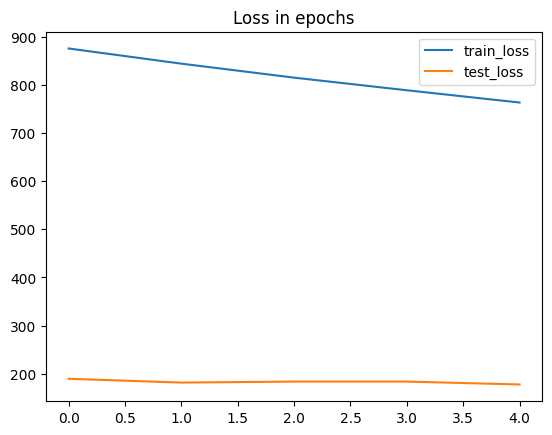

In [28]:
#draw loss graph
train_losses=[tl.item() for tl in train_loss]
test_losses=[tl.item() for tl in test_loss]
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.title("Loss in epochs")
plt.legend()

In [8]:
#draw accuracy graph
train_accuracy=[crr.item()/12000 for crr in train_correct]
test_accuracy=[crr.item()/2000 for crr in train_correct]
plt.plot(train_accuracy,label='train_accuracy')
plt.plot(test_accuracy,label='test_accuracy')
plt.title("accuracy in epochs")
plt.legend()

NameError: name 'train_correct' is not defined

In [54]:
#real picture test
def read_picture(image_path):
    pic=Image.open(image_path)
    transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  ])
    
    pic=transform(pic).reshape(1,3,32,32)
    return pic

def predict(pic):
    model.load_state_dict(torch.load('D:\BaiduSyncdisk\Edith\Study\CNN\model_parameters\model.pth'))
    model.eval()
    outputs=model(pic)
    predicted=torch.max(outputs,1)[1]
    label=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    print(f'This is a {label[predicted]}')

def show_image(image_path):
    pic=Image.open(image_path)
    transform = transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.ToPILImage()])
    img_pil = transform(pic)
    plt.imshow(img_pil)
    plt.axis('off')  # 关闭坐标轴显示
    plt.show()


torch.Size([1, 3, 32, 32])


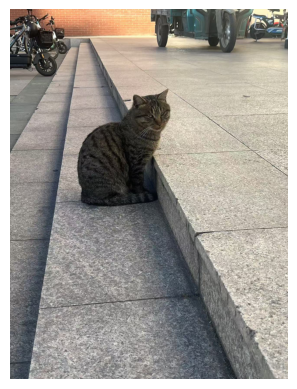

This is a cat


In [64]:
pic=read_picture(r"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\maomao.jpg")
print(pic.shape)
show_image(r"D:\BaiduSyncdisk\Edith\Study\3(1)\AI\catsanddogs\maomao.jpg")
predict(pic)